In [1]:
import os

import scipy
import numpy as np
import matplotlib.pyplot as plt
from Bio import SeqIO

from helperFxns import lett2num, alg2bin, filterAln, simMat


['A.fasta', 'B.fasta', 'C.fasta', 'D.fasta']
After filtering, the number of filtered sequences for file A.fasta: 2984
After filtering, the number of filtered positions for file A.fasta: 161
The mean sequence identity for file A.fasta: 0.455
After filtering, the number of filtered sequences for file B.fasta: 2888
After filtering, the number of filtered positions for file B.fasta: 264
The mean sequence identity for file B.fasta: 0.524
After filtering, the number of filtered sequences for file C.fasta: 3154
After filtering, the number of filtered positions for file C.fasta: 267
The mean sequence identity for file C.fasta: 0.424
After filtering, the number of filtered sequences for file D.fasta: 3519
After filtering, the number of filtered positions for file D.fasta: 401
The mean sequence identity for file D.fasta: 0.568


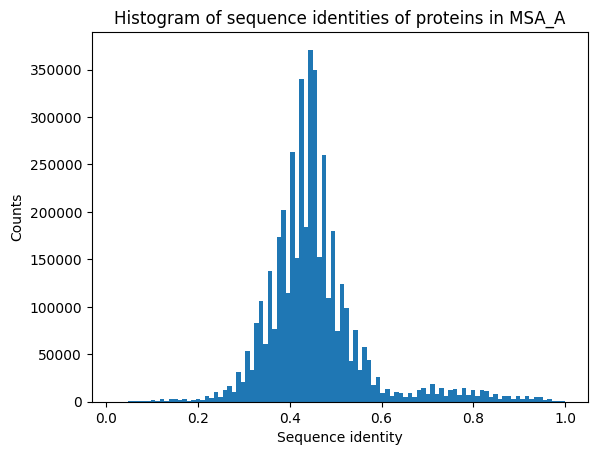

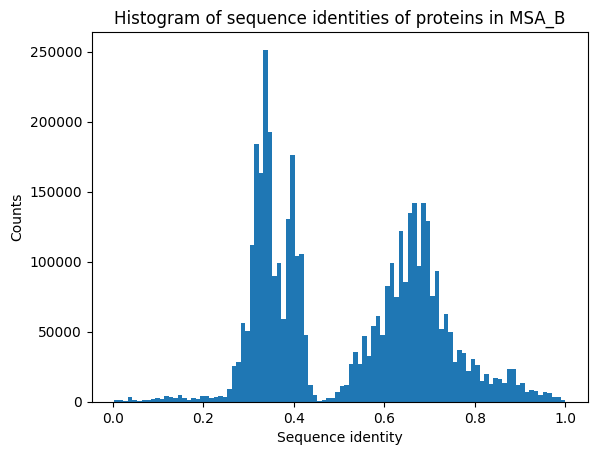

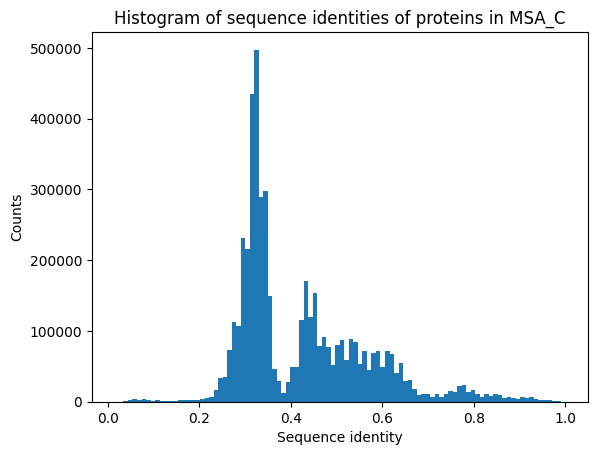

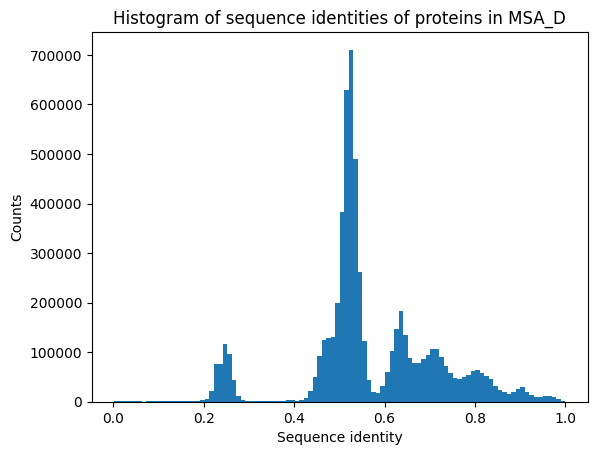

In [6]:
files = [file for file in os.listdir() if file.endswith('.fasta')]
print(files)

for file in files:
    # read the file with the Bio.SeqIO module
    encoding_file = file.split('.')[0] + '_one-hot.npy'
    header_file = file.split('.')[0] + '_header.txt'
    filter_header_file = file.split('.')[0] + '_filter_header.txt'
    headers = []
    seqs = []
    for seq_record in SeqIO.parse(file, "fasta"):
        header = '>' + str(seq_record.description)
        headers.append(header)
        seq = str(seq_record.seq)
        seqs.append(seq)


    with open(header_file, 'w') as f:
        for header in headers:
            f.write(header)
            f.write('\n')

    # one-hot encode the sequences
    num = lett2num(seqs, code='ACDEFGHIKLMNPQRSTVWY-')
    bin = alg2bin(num, N_aa=21)

    # filter out highly gapped positions and sequences according to the cutoff
    hdFilter, seqFilter = filterAln(headers, num)

    # print(seqFilter.shape)
    print("After filtering, the number of filtered sequences for file {}: {}".format(file, seqFilter.shape[0]))
    print("After filtering, the number of filtered positions for file {}: {}".format(file, seqFilter.shape[1]))
    # print(len(hdFilter))

    with open(filter_header_file, 'w') as f:
        for header in hdFilter:
            f.write(header)
            f.write('\n')

    filter_bin = alg2bin(seqFilter, N_aa=21)

    # compute a sequence identity matrix
    sim = simMat(filter_bin, seqFilter.shape[1])

    # sim is a symmetric matrix, get the values above the diagonal
    sim_diag = sim[np.triu_indices(sim.shape[0], k=1)]
    # convert to a shape (n,) array
    sim_diag = np.array(sim_diag).reshape(-1)
    
    # calculate the mean of the sequence identities
    mean_sim = np.mean(sim_diag)
    print("The mean sequence identity for file {}: {}".format(file, round(mean_sim, 3)))

    # plot the histogram of sequence identities for each MSA
    plt.figure()
    plt.hist(sim_diag, bins=100)
    plt.xlabel('Sequence identity')
    plt.ylabel('Counts')
    plt.title('Histogram of sequence identities of proteins in MSA_{}'.format(
        file.split('.')[0]))
    # plt.show()
    plt.savefig(file.split('.')[0] + '_hist.png')


As we can see, MSA D shows the highest sequence identity to the query sequence, and we can conclude that MSA D is the most conserved MSA among the four MSAs.

By plotting the sequence identity of each MSA, we can see that for MSA B, C, and D, the histogram has few peaks, which might indicate that there might be phylogenetic structure for the MSA. Further work, like phylogenetic tree construction, might be useful for further validation, and we are interested in such analysis in the future.